In [2]:
# ML Data Extraction Prototype
# This notebook will connect to the database, extract and join the tables needed
# to begin feature engineering for the next-race prediction model.

# 1. Imports and engine setup
import pandas as pd
from sqlalchemy import create_engine, text
from Data_Import.database import get_engine

# Create SQLAlchemy engine
engine = get_engine(echo=False)

In [3]:
# 2. Inspect available tables
with engine.connect() as conn:
    tables = conn.execute(text("SELECT table_name FROM information_schema.tables WHERE table_schema='public';")).fetchall()
tables_list = [t[0] for t in tables]
print("Available tables:", tables_list)

Available tables: ['athlete_rankings', 'athlete', 'race_results', 'events']


In [4]:
# 3. Load raw tables into DataFrames
# Athlete dimension
athletes_df = pd.read_sql_table('athlete', engine)
# Events dimension
events_df   = pd.read_sql_table('events', engine)
# Race results fact table
results_df  = pd.read_sql_table('race_results', engine)

print(f"Athletes: {len(athletes_df)} rows")
print(f"Events: {len(events_df)} rows")
print(f"Race results: {len(results_df)} rows")


#athletes_df.head()
#events_df.head()
#results_df.head() 

Athletes: 1921 rows
Events: 3357 rows
Race results: 63548 rows


In [5]:
# 4. Join tables for ML dataset
# Convert EventDate to datetime for feature engineering
events_df['EventDate'] = pd.to_datetime(events_df['EventDate'])
# Merge results with events and athletes
ml_df = (
    results_df
    .merge(events_df, on='EventID', how='left')
    .merge(athletes_df, left_on='athlete_id', right_on='athlete_id', how='left')
)

print(f"ML dataset shape: {ml_df.shape}")
#ml_df.head()

ML dataset shape: (63548, 28)


In [6]:
# 5. Data Cleaning 

# a. Drop uneeded rows
ml_df = ml_df.drop(columns=['EventSpecifications_y', 'CategoryName_y', 'category_medical'])
ml_df = ml_df.rename(columns={'EventSpecifications_x': 'EventSpecifications', 'CategoryName_x': 'CategoryName'})

In [7]:
# b. Define Catgories to splite EventSpecifications
race_types = {'Triathlon', 'Duathlon', 'Aquathlon', "Winter Duathlon", 'Aquabike'}
distances = {'Sprint', 'Standard', 'Super Sprint', 'Long Distance', 'Middle Distance', 'Olympic', 'Ironman'}
other_flags = {'Paratriathlon', 'Mixed Relay', 'Relay', 'Aquabike'}

def parse_event_specs(spec_string):
    if not isinstance(spec_string, str):
        return pd.Series([None, None, None])
    items = [s.strip() for s in spec_string.split(',')]
    # Find matches
    race = next((x for x in items if x in race_types), None)
    distance = next((x for x in items if x in distances), None)
    # Other flags: those in other_flags, or anything else not found above
    others = [x for x in items if x in other_flags or (x not in race_types and x not in distances)]
    return pd.Series([race, distance, ', '.join(others) if others else None])

# c. Create seperate columns for race specific information and drop non tri/paratri event
ml_df[['race_type', 'distance', 'event_flags']] = ml_df['EventSpecifications'].apply(parse_event_specs)
ml_df = ml_df[~ml_df['race_type'].isin(['Duathlon', 'Aquathlon', 'Winter Duathlon', 'Aquabike'])]
ml_df = ml_df.dropna(subset=['BikeTime', 'T2', 'SwimTime', 'RunTime', 'T1', 'age', 'EventSpecifications'])

# d. Simplify event_flags into a single `event_mode` feature
# Split event_flags into a list, handling NaNs
ml_df['flags_list'] = ml_df['event_flags'].fillna('').apply(
    lambda x: [s.strip() for s in x.split(',') if s.strip()]
)

# Define the flags we care about
allowed_flags = {'Mixed Relay', 'Paratriathlon'}

# Create boolean indicator columns
ml_df['is_mixed_relay']     = ml_df['flags_list'].apply(lambda lst: 'Mixed Relay' in lst).astype(int)
ml_df['is_paratriathlon']   = ml_df['flags_list'].apply(lambda lst: 'Paratriathlon' in lst).astype(int)

# Drop any row where there are OTHER flags besides our two
ml_df = ml_df[ ml_df['flags_list'].apply(lambda lst: set(lst).issubset(allowed_flags)) ]

# Collapse into one categorical feature
def determine_event_mode(row):
    if row['is_mixed_relay'] and row['is_paratriathlon']:
        return 'para_mixed_relay'
    if row['is_mixed_relay']:
        return 'mixed_relay'
    if row['is_paratriathlon']:
        return 'paratriathlon'
    return 'individual'

ml_df['event_mode'] = ml_df.apply(determine_event_mode, axis=1)

# Clean up helper columns
ml_df.drop(columns=['event_flags', 'flags_list', 'EventSpecifications'], inplace=True)

# Check distribution
print(ml_df['event_mode'].value_counts())

event_mode
individual          45188
mixed_relay         11973
para_mixed_relay     1367
paratriathlon         972
Name: count, dtype: int64


In [8]:
# 6. DNF Handling

# A. Flag DNF/DNS rows
ml_df['DNF_flag'] = ml_df['TotalTime'].isin(['DNF', 'DNS']).astype(int)

# B. Recent DNF rates per athlete (rolling window)
ml_df = ml_df.sort_values(['athlete_id', 'EventDate'])
ml_df['recent_5_DNF_rate'] = (
    ml_df.groupby('athlete_id')['DNF_flag']
    .rolling(window=5, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)

# C. Filter for rows with a valid TotalTime for regression/classification models
ml_df_valid = ml_df[ml_df['TotalTime'].str.match(r'^\d{2}:\d{2}:\d{2}$', na=False)].copy()

print(f"ML dataset (non-DNF rows): {ml_df_valid.shape}")

# 7. Save or cache the cleaned DataFrames for next steps
ml_df.to_parquet('data/ml_raw_dataset_with_dnf.parquet', index=False)
ml_df_valid.to_parquet('data/ml_raw_dataset_valid_only.parquet', index=False)
print("ML datasets saved: with DNF indicators and valid-only rows.")


ML dataset (non-DNF rows): (53964, 31)
ML datasets saved: with DNF indicators and valid-only rows.
ML datasets saved: with DNF indicators and valid-only rows.


In [9]:
#8. Feature Engineering

df = ml_df_valid.copy()  # Work on a copy to preserve your clean data

# 8.1. Calculate rolling averages (last 3 and last 5 races) for each athlete
df = df.sort_values(['athlete_id', 'EventDate'])

# Convert finish time to seconds for numeric rolling average
df['TotalTime_sec'] = pd.to_timedelta(df['TotalTime']).dt.total_seconds()
df['Position'] = pd.to_numeric(df['Position'], errors='coerce')
df = df[df['TotalTime_sec'] > 600]


df['rolling3_time_dist'] = (
    df
      .sort_values(['athlete_id','EventDate'])
      .groupby(['athlete_id','distance'])['TotalTime_sec']
      .rolling(window=3, min_periods=1)
      .mean()
      .reset_index(level=[0,1], drop=True)
)
df['rolling5_time_dist'] = (
    df
      .groupby(['athlete_id','distance'])['TotalTime_sec']
      .rolling(window=5, min_periods=1)
      .mean()
      .reset_index(level=[0,1], drop=True)
)
df['rolling5_time_all'] = (
    df
      .groupby('athlete_id')['TotalTime_sec']
      .rolling(window=5, min_periods=1)
      .mean()
      .reset_index(level=0, drop=True)
)

df['rolling3_pos'] = (
    df.groupby('athlete_id')['Position'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
)
df['rolling5_pos'] = (
    df.groupby('athlete_id')['Position'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
)

# 8.2. Days since last race
df['days_since_last'] = (
    df.groupby('athlete_id')['EventDate'].diff().dt.days
)

# 8.3. Age at race date (if you have a column like athlete_yob)
if 'athlete_yob' in df.columns:
    df['age_at_race'] = df['EventDate'].dt.year - df['athlete_yob']

# 8.4. Encode categorical features (optional: you may want to keep as string for now)
# One-hot encoding for race_type, distance, event_flags (if not too many unique)
df = pd.get_dummies(df, columns=['race_type', 'distance', 'event_mode'], prefix=['rt', 'dist', 'mode'])

ml_df_valid = df
ml_df_valid.head()

,athlete_id,EventID,ProgID,Program,CategoryName,Position,TotalTime,SwimTime,T1,BikeTime,...,rolling5_pos,days_since_last,rt_Triathlon,dist_Sprint,dist_Standard,dist_Super Sprint,mode_individual,mode_mixed_relay,mode_para_mixed_relay,mode_paratriathlon
63001,6120,5011,3411,Junior Women,Continental Championships,14.0,01:11:51,00:11:37,00:00:54,00:39:12,...,14.000000,NaN,True,True,False,False,True,False,False,False
63000,6120,4489,3333,Junior Women,World Championships,10.0,01:10:37,00:10:38,00:00:00,00:38:53,...,12.000000,168.0,True,True,False,False,True,False,False,False
62999,6120,4492,3326,U23 Women,World Championships,14.0,02:02:19,00:20:19,00:01:30,01:00:54,...,12.666667,155.0,True,True,False,False,True,False,False,False
62998,6120,4541,1812,Elite Women,World Cup,12.0,02:16:25,00:23:43,00:00:00,01:12:52,...,12.500000,357.0,True,False,True,False,True,False,False,False
62997,6120,4588,1908,U23 Women,Continental Championships,9.0,02:11:09,00:20:36,00:00:41,01:11:05,...,11.800000,77.0,True,False,True,False,True,False,False,False


In [10]:
# 9. Label Creation: next-race finish time & position

# Work off your cleaned, feature-engineered DataFrame:
df = ml_df_valid.copy()

# Ensure it’s sorted
df = df.sort_values(['athlete_id','EventDate'])

# Create next‐race labels
df['next_time_sec'] = (
    df.groupby('athlete_id')['TotalTime_sec']
      .shift(-1)
)
df['next_position'] = (
    df.groupby('athlete_id')['Position']
      .shift(-1)
)

# (Optional) if you want human‐readable next time:
import pandas as pd
df['next_time'] = pd.to_timedelta(df['next_time_sec'], unit='s').astype(str)

# Drop rows without a next race (i.e. final race per athlete)
df_model = df.dropna(subset=['next_time_sec','next_position']).reset_index(drop=True)

print("Shape after label creation:", df_model.shape)
df_model[['athlete_id','EventDate','TotalTime','next_time','Position','next_position']].head(10)


Shape after label creation: (51753, 46)


,athlete_id,EventDate,TotalTime,next_time,Position,next_position
0,6120,2003-06-21,01:11:51,0 days 01:10:37,14.0,10.0
1,6120,2003-12-06,01:10:37,0 days 02:02:19,10.0,14.0
2,6120,2004-05-09,02:02:19,0 days 02:16:25,14.0,12.0
3,6120,2005-05-01,02:16:25,0 days 02:11:09,12.0,9.0
4,6120,2005-07-17,02:11:09,0 days 02:12:17,9.0,17.0
5,6120,2005-08-20,02:12:17,0 days 02:07:24,17.0,10.0
6,6120,2005-09-10,02:07:24,0 days 02:06:16,10.0,6.0
7,6120,2006-02-19,02:06:16,0 days 02:06:32,6.0,22.0
8,6120,2006-03-26,02:06:32,0 days 02:11:22,22.0,27.0
9,6120,2006-06-04,02:11:22,0 days 02:07:59,27.0,20.0


In [13]:
#Model Creation Scaffolding

from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

df = df_model

numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_features + categorical_features)
])

pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", LinearRegression())
])

pipeline_rf = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])

#Evaluate with GroupKFold cross-validation
cv = GroupKFold(n_splits=5)
neg_mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [14]:
def remove_outliers(df, col='TotalTime_sec'):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] > Q1 - 1.5 * IQR) & (df[col] < Q3 + 1.5 * IQR)]


In [12]:
# 2. Define features, target, and grouping
# Before selecting features transform column names to strings. …
df.columns = [str(col) for col in df.columns]

numeric_features = [
    "TotalTime_sec", "days_since_last", "age",
    "rolling3_time_dist", "rolling5_time_dist",
    "rolling3_pos", "rolling5_pos"
]
categorical_features = [
    "rt_Triathlon", "dist_Sprint", "dist_Standard", "dist_Super Sprint",
    "mode_individual", "mode_mixed_relay", "mode_para_mixed_relay", "mode_paratriathlon"
]

# Course string conversion. 
for col in numeric_features:
    df[col] = pd.to_numeric(df[col], errors='coerce')
for col in categorical_features:
    # If your dummies are 0/1:
    df[col] = df[col].astype(float)  # or int

X = df[numeric_features + categorical_features]
y = df["next_time_sec"]
groups = df["athlete_id"]

In [15]:
# 3. Loop through each distance and run the same pipeline

for dist in ['dist_Sprint', 'dist_Standard', 'dist_Super Sprint']:
    print(f"\n--- Modeling for {dist} ---")
    df_dist = df[df[dist] == 1]
    remove_outliers(df_dist)
    # Athlete-mean baseline
    athlete_means = df_dist.groupby('athlete_id')['TotalTime_sec'].mean()
    baseline_preds = df_dist['athlete_id'].map(athlete_means)
    mae = (df_dist['next_time_sec'] - baseline_preds).abs().mean()
    print(f"Athlete-specific mean predictor MAE: {mae:.2f} sec")

    ''''sample_athletes = df_dist['athlete_id'].value_counts().index[:5]
    for aid in sample_athletes:
        plt.plot(
            df_dist[df_dist['athlete_id'] == aid].sort_values('EventDate')['EventDate'],
            df_dist[df_dist['athlete_id'] == aid].sort_values('EventDate')['TotalTime_sec'],
            label=f"Athlete {aid}"
        )
    plt.legend()
    plt.ylabel('Finish Time (sec)')
    plt.title(f'Finish Time Over Time for Athletes in {dist}')
    plt.show()

   
    print(df_dist[['rolling3_time_dist', 'rolling5_time_dist', 'TotalTime_sec', 'next_time_sec']].corr())
    # For scatterplot
    plt.scatter(df_dist['rolling3_time_dist'], df_dist['next_time_sec'])
    plt.xlabel('Rolling 3 Time (Dist)')
    plt.ylabel('Next Time Sec')
    plt.title(f'Predictive Power of Rolling 3 for {dist}')
    plt.show()


    '''# Features and targets
    available_features = [col for col in numeric_features + categorical_features if col in df_dist.columns]
    X_dist = df_dist[available_features]
    y_dist = df_dist['next_time_sec']
    groups_dist = df_dist['athlete_id']

    if len(df_dist) == 0:
        print(f"No data for {dist}")
        continue

    # Linear model
    cv_scores = cross_val_score(
        pipeline, X_dist, y_dist, cv=cv, groups=groups_dist, scoring=neg_mae_scorer
    )
    print(f"Linear Model MAE per fold: {-cv_scores}")
    print(f"Linear Model Avg MAE: {-cv_scores.mean():.2f} seconds")

    # Random Forest
    cv_scores_rf = cross_val_score(
        pipeline_rf, X_dist, y_dist, cv=cv, groups=groups_dist, scoring=neg_mae_scorer
    )
    print(f"Random Forest MAE per fold: {-cv_scores_rf}")
    print(f"Random Forest Avg MAE: {-cv_scores_rf.mean():.2f} seconds")

    '''
    pipeline_rf.fit(X_dist, y_dist)
    importances = pipeline_rf.named_steps['model'].feature_importances_
    for name, imp in zip(X_dist.columns, importances):
        print(f"{name}: {imp:.4f}")'''

cv_scores = cross_val_score(
    pipeline, X, y, cv=cv, groups=groups, scoring=neg_mae_scorer
)

'''
print(f"\n--- Modeling for full dataset ---")
print("MAE per fold:", -cv_scores)
print("Average MAE:", -cv_scores.mean())
'''
# 6. Fit final model on all data
#pipeline.fit(X, y)
# Serialize for future use
#import joblib
#joblib.dump(pipeline, "baseline_regression_pipeline_v1.pkl")


--- Modeling for dist_Sprint ---
Athlete-specific mean predictor MAE: 1289.72 sec
Linear Model MAE per fold: [1378.85990363 1401.82199872 1406.0560297  1412.21978368 1409.43384282]
Linear Model Avg MAE: 1401.68 seconds
Linear Model MAE per fold: [1378.85990363 1401.82199872 1406.0560297  1412.21978368 1409.43384282]
Linear Model Avg MAE: 1401.68 seconds
Random Forest MAE per fold: [1386.51855954 1427.92721421 1422.57439637 1420.69155367 1428.79327535]
Random Forest Avg MAE: 1417.30 seconds

--- Modeling for dist_Standard ---
Athlete-specific mean predictor MAE: 2128.70 sec
Linear Model MAE per fold: [1863.13492926 1807.64276907 1847.28793936 1824.51519069 1857.33409543]
Linear Model Avg MAE: 1839.98 seconds
Random Forest MAE per fold: [1386.51855954 1427.92721421 1422.57439637 1420.69155367 1428.79327535]
Random Forest Avg MAE: 1417.30 seconds

--- Modeling for dist_Standard ---
Athlete-specific mean predictor MAE: 2128.70 sec
Linear Model MAE per fold: [1863.13492926 1807.64276907 18

'\nprint(f"\n--- Modeling for full dataset ---")\nprint("MAE per fold:", -cv_scores)\nprint("Average MAE:", -cv_scores.mean())\n'

In [16]:
#df['TotalTime_sec'].describe()
# Baseline: mean per distance
for dist in ['dist_Sprint', 'dist_Standard', 'dist_Super Sprint']:
    mask = df[dist] == 1
    mae = abs(df[mask]['TotalTime_sec'] - df[mask]['TotalTime_sec'].mean()).mean()
    print(f"Baseline MAE for {dist}: {mae:.2f} seconds")

Baseline MAE for dist_Sprint: 674.12 seconds
Baseline MAE for dist_Standard: 832.63 seconds
Baseline MAE for dist_Super Sprint: 437.52 seconds


In [ ]:
# Exploratory EDA
# Use only valid rows for EDA on finish time
eda_df = ml_df_valid.copy()

# Null/NA check
print(eda_df.isnull().sum().sort_values(ascending=False))


event_flags                41417
CategoryName                5739
Venue                       3656
distance                    1452
race_type                    794
athlete_id                     0
Position                       0
TotalTime                      0
SwimTime                       0
T1                             0
EventID                        0
ProgID                         0
Program                        0
EventSpecifications            0
EventName                      0
RunTime                        0
T2                             0
BikeTime                       0
gender                         0
EventDate                      0
Country                        0
full_name                      0
category_to                    0
age                            0
country                        0
category_coach                 0
category_paratriathlete        0
category_athlete               0
DNF_flag                       0
recent_5_DNF_rate              0
dtype: int

In [ ]:

# Data types and summary
#print(eda_df.dtypes)
#print(eda_df.describe(include='all'))

# Unique values per column (quick profiling)
for col in eda_df.columns:
    print(f"{col}: {eda_df[col].nunique()} unique values")


athlete_id: 1913 unique values
EventID: 2812 unique values
ProgID: 5914 unique values
Program: 72 unique values
CategoryName: 44 unique values
EventSpecifications: 69 unique values
Position: 110 unique values
TotalTime: 6792 unique values
SwimTime: 3043 unique values
T1: 800 unique values
BikeTime: 6515 unique values
T2: 620 unique values
RunTime: 4861 unique values
EventName: 2808 unique values
EventDate: 1419 unique values
Venue: 854 unique values
Country: 121 unique values
full_name: 1913 unique values
gender: 2 unique values
country: 111 unique values
age: 38 unique values
category_to: 2 unique values
category_coach: 2 unique values
category_athlete: 2 unique values
category_paratriathlete: 2 unique values
race_type: 1 unique values
distance: 5 unique values
event_flags: 20 unique values
DNF_flag: 1 unique values
recent_5_DNF_rate: 10 unique values


In [ ]:
ml_df['event_flags'].value_counts()

event_flags
Mixed Relay                                     11973
Mixed Relay, Paratriathlon                       1367
Paratriathlon                                     972
Long Distance Triathlon                           251
Relay, Mixed Relay                                197
Cross Triathlon                                   116
Relay                                             112
Mixed Relay, Eliminator                           108
Cross Triathlon, Paratriathlon                     90
Winter Triathlon, Mixed Relay, Paratriathlon       52
Relay, Paratriathlon                               33
Long Distance Triathlon, Paratriathlon             31
Winter Triathlon                                   31
Cross Duathlon, Paratriathlon                      27
Eliminator                                         20
Cross Duathlon                                     14
Cross Duathlon, Relay                              11
Winter Triathlon, Relay                             6
Cross Duathlon, 

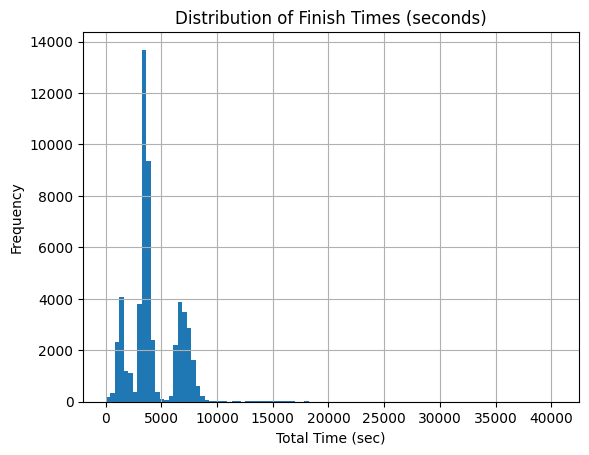

In [ ]:
# Quick outlier detection for finish time
import matplotlib.pyplot as plt
eda_df['TotalTime_sec'] = pd.to_timedelta(eda_df['TotalTime']).dt.total_seconds()
eda_df['TotalTime_sec'].hist(bins=100)
plt.title('Distribution of Finish Times (seconds)')
plt.xlabel('Total Time (sec)')
plt.ylabel('Frequency')
plt.show()

# Additional Model Considerations

1. **Competition Level Features**
   - Calculate field strength based on participant rankings
   - Weight recent performances more heavily
   - Consider race importance (championship vs regular)

2. **Splits-Based Modeling**
   - Model each discipline separately (swim/bike/run)
   - Account for transition times
   - Capture athlete strengths per discipline

In [17]:
# Field Strength Feature Engineering

def calculate_field_strength(df):
    # Group by event and calculate mean ranking of participants
    field_strength = df.groupby('EventID').agg({
        'athlete_rank': ['mean', 'min', 'max', 'count']
    })
    return field_strength

# Discipline-specific modeling preparation
def prepare_split_features(df):
    splits = ['SwimTime', 'BikeTime', 'RunTime']
    for split in splits:
        # Convert to seconds if string format
        if df[split].dtype == 'object':
            df[f'{split}_sec'] = pd.to_timedelta(df[split]).dt.total_seconds()
        # Calculate rolling averages per split
        df[f'{split}_rolling3'] = df.groupby('athlete_id')[f'{split}_sec'].rolling(3).mean().reset_index(0, drop=True)
    return df

In [18]:
# Field Strength Calculation (Plan Step 1)
def calculate_field_strength(event_df):
    '''
    Calculate field strength for each event based on participant count, mean/std position, and athlete ranking stats.
    Args:
        event_df (pd.DataFrame): DataFrame with at least ['EventID', 'Position', 'athlete_rank'] columns.
    Returns:
        pd.DataFrame: Aggregated stats per EventID.
    '''
    return event_df.groupby('EventID').agg({
        'Position': ['count', 'mean', 'std'],
        'athlete_rank': ['min', 'max', 'mean']
    })

In [19]:
# Split-Time Processing (Plan Step 1)
def group_rolling_mean(df, split, window):
    '''
    Helper to compute rolling mean for a split column (in seconds) per athlete.
    '''
    return df.groupby('athlete_id')[split].rolling(window, min_periods=1).mean().reset_index(0, drop=True)

def process_split_times(df):
    '''
    Adds split time in seconds and rolling 3-race mean for Swim, Bike, Run splits.
    '''
    for split in ['SwimTime', 'BikeTime', 'RunTime']:
        df[f'{split}_sec'] = pd.to_timedelta(df[split]).dt.total_seconds()
        df[f'{split}_rolling3'] = group_rolling_mean(df, f'{split}_sec', 3)
    return df

In [20]:
# Save the fully feature-engineered and labeled dataset for model testing
df_model.to_parquet('data/ml_model_dataset.parquet', index=False)
print('Saved df_model to data/ml_model_dataset.parquet')

Saved df_model to data/ml_model_dataset.parquet
